In [1]:
import numpy as np
from numpy import radians
from lib.cartpolesystem import CartPoleDCMotorSystem, Cart, Pole
from lib.motors import DCMotor
from lib.cartpoleenv import CartPoleEnv
from lib.direct_collocation import DirectCollocation
from lib.controllers import LQR
from time import perf_counter
from matplotlib import pyplot as plt
from lib.numerical import rk4_step

In [2]:
dt = 0.01
g = 9.81

cart = Cart(1, 0.01, (-0.8, 0.8), 0.25)
motor = DCMotor(0.2, 0.2, 0.2, 0.05, 8.7e-5, 8.7e-5, (-24, 24), 0.1, (-100, 100), 0.1)
poles = [Pole(2, 0.2, 0.1), Pole(1, 0.3, 0.1)]
n = len(poles)

system = CartPoleDCMotorSystem(cart, motor, poles, g)

max_time = 10
N_env = int(max_time/dt)

env = CartPoleEnv(system, dt, N_env, rk4_step)
env.observation_space.shape

c:\Users\sacka\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


(6,)

Optimizing trajectory...


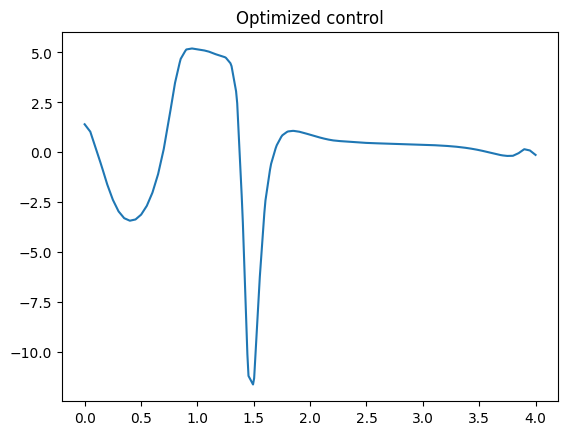

In [3]:
end_time = 4
dt_collocation = 0.05
N_collocation = int(end_time/dt_collocation)+1

N = int(end_time/dt)

direct_collocation = DirectCollocation(
    N_collocation,
    system.differentiate, 
    system.state_lower_bound.shape[0],
    system.control_lower_bound.shape[0],
    system.constraints,
    system.calculate_error,
    0.001
)

x0 = np.array([0, 0] + [radians(180), 0]*n)

r = np.array([0.1, 0] + [0, 0]*n)

last_update = perf_counter()

print("Optimizing trajectory...")
states, controls = direct_collocation.make_controller(end_time, x0, r, N)

time = np.linspace(0, end_time, N)

plt.title("Optimized control")
plt.plot(time, controls.T[0])
plt.show()

In [4]:
np.set_printoptions(precision=1)

linearization_x0 = np.zeros(2+2*n)
linearization_u0 = np.array([0])

A0, B0 = system.linearize(linearization_x0, linearization_u0)

C = np.diag([1, 1]+[1, 1]*n)

D = np.zeros((1, 1))

ct_dt = dt

lqr = LQR(ct_dt)

Q = np.diag([10, 1]+[100, 1]*n)
R = np.diag([1])

A_d0, B_d0 = lqr.discretize(A0, B0, C, D)
K_d0 = lqr.calculate_K_d(A_d0, B_d0, Q, R)

print("A:", A0)
print("B:", B0)

A: [[ 0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00 -2.9e+01 -3.1e+00  1.6e-01 -1.5e+00  1.0e-01]
 [ 0.0e+00  0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00  1.2e+02  5.5e+01 -2.8e+00  6.6e+00 -4.5e-01]
 [ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00]
 [ 0.0e+00  8.3e+01  8.7e+00 -4.5e-01  3.2e+01 -2.2e+00]]
B: [[  0. ]
 [  7.3]
 [  0. ]
 [-31.2]
 [  0. ]
 [-20.8]]


In [5]:
print("Calculating As and Bs...")
As, Bs = np.vectorize(system.linearize, signature='(n),(m)->(n,n),(n,m)')(states, controls)

Calculating As and Bs...


In [6]:
print("Calculating A_ds and B_ds...")
A_ds, B_ds = np.vectorize(lqr.discretize, signature='(n,n),(n,m),(a,b),(c,d)->(n,n),(n,m)')(As, Bs, C, D)
print("Calculating K_ds...")
_, K_ds = lqr.calculate_finite_K_ds(A_ds, B_ds, Q, R)

Calculating A_ds and B_ds...
Calculating K_ds...


In [7]:
print("Memory usage K_ds: ", (K_ds.nbytes)/1024**1, "KB")

Memory usage K_ds:  18.75 KB


In [8]:
last_update = perf_counter()

state, _ = env.reset(x0)

errors = np.zeros((N_env, 2+2*n))

for i in range(N_env-1):
    while perf_counter() < last_update + dt:
        pass    
    last_update = perf_counter()

    error = np.zeros(2+2*n)
    if i < N*1:
        error = system.calculate_error(state, states[i])
        u_ff = controls[i]
        u_fb = lqr.feedback(K_ds[i], error)
        u = u_ff + u_fb
    else:
        error = system.calculate_error(state, states[-1])
        u = lqr.feedback(K_ds[-1], error)
    errors[i] = error

    state, reward, done, msg, _ = env.step(u)
    env.render()

env.close()

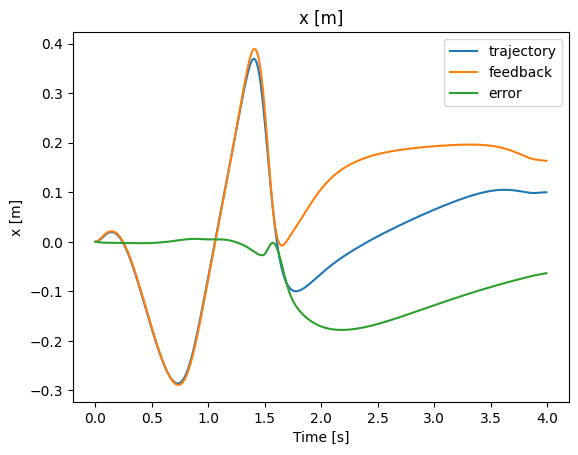

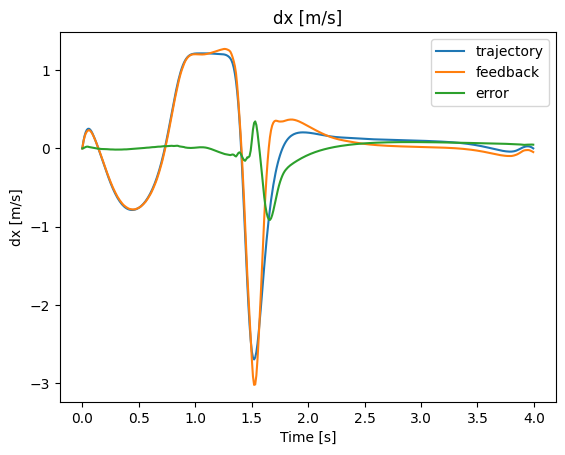

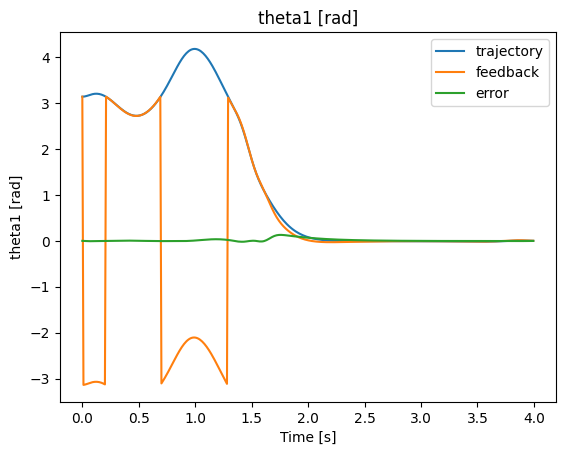

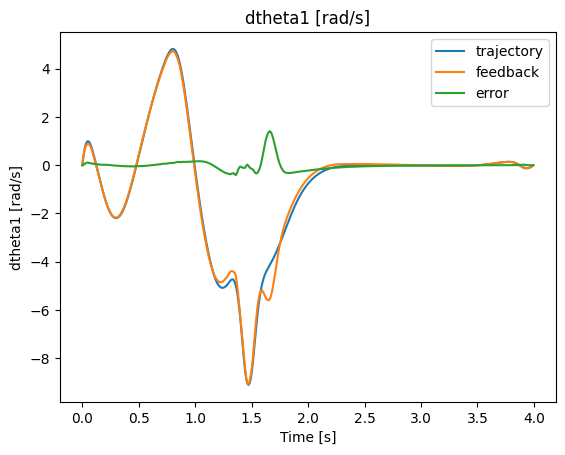

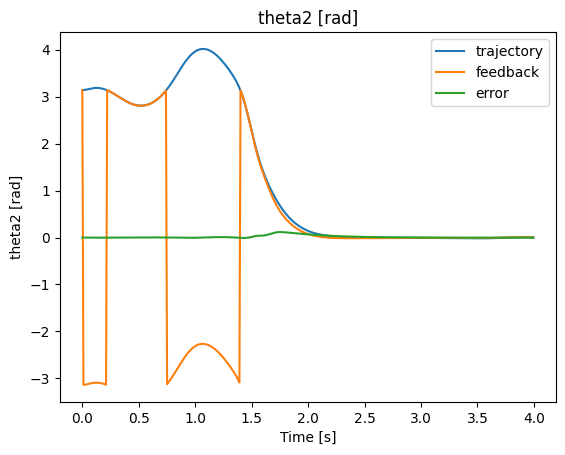

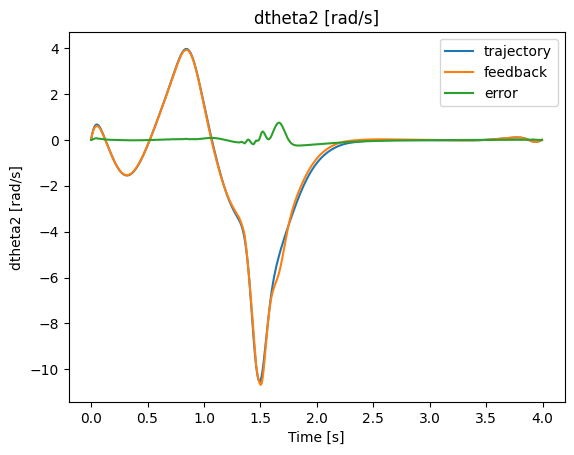

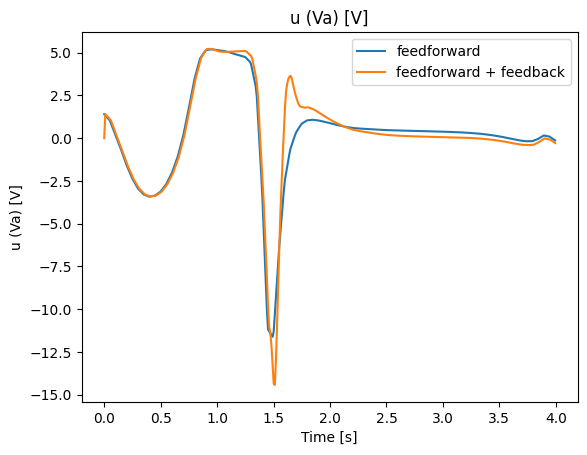

In [9]:
time = np.linspace(0, max_time, N_env)
labels = ["x [m]", "dx [m/s]", "theta1 [rad]", "dtheta1 [rad/s]", "theta2 [rad]", "dtheta2 [rad/s]"]
for i in range(2+2*n):
    plt.xlabel("Time [s]")
    plt.ylabel(labels[i])
    plt.title(labels[i])
    plt.plot(time[:N], states.T[i][:N], label="trajectory")
    plt.plot(time[:N], env.states.T[i][:N], label="feedback")
    plt.plot(time[:N], errors.T[i][:N], label="error")
    plt.legend()
    plt.show()
plt.title("u (Va) [V]")
plt.xlabel("Time [s]")
plt.ylabel("u (Va) [V]")
plt.plot(time[:N], controls.T[0][:N], label="feedforward")
plt.plot(time[:N], env.controls.T[0][:N], label="feedforward + feedback")
plt.legend()
plt.show()